In [27]:
%reset -f

# VGG16

# GridsearchCV

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from scikeras.wrappers import KerasClassifier
from PIL import Image

# Load and preprocess data functions
def load_data(dataset_dir):
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    images = []
    labels = []

    for category in categories:
        path = os.path.join(dataset_dir, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            label = category
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  # Proper resizing using PIL
            img = np.array(img)
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

def preprocess_data(x, y):
    x = x / 255.0
    label_encoder = LabelEncoder()
    y_int = label_encoder.fit_transform(y)
    y = to_categorical(y_int, num_classes=4)
    return x, y, y_int, label_encoder

# Load data
x, y = load_data('dataset_16')

# Split the data: 70% training, 15% validation, 15% test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Display class distribution for training, validation, and test data
train_class_count = Counter(np.argmax(y_train, axis=1))
val_class_count = Counter(np.argmax(y_val, axis=1))
test_class_count = Counter(np.argmax(y_test, axis=1))

print("Training set class distribution:", train_class_count)
print("Validation set class distribution:", val_class_count)
print("Test set class distribution:", test_class_count)

# Normalize and preprocess images
x_train, y_train, y_train_int, label_encoder = preprocess_data(x_train, y_train)
x_val, y_val, y_val_int, _ = preprocess_data(x_val, y_val)
x_test, y_test, y_test_int, _ = preprocess_data(x_test, y_test)

# Function to create the model
def create_model(optimizer='adam', learning_rate=0.001, neurons=512, dropout_rate=0.0):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(neurons, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)  # 4 output classes
    model = Model(inputs=base_model.input, outputs=x)
    
    for layer in base_model.layers:
        layer.trainable = False

    optimizer = optimizer.lower()
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        opt = Adamax(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the Keras model
model = KerasClassifier(model=create_model, verbose=0)

# Define the expanded grid search parameters
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'model__optimizer': ['adam', 'sgd', 'adamax'],
    'model__learning_rate': [0.001, 0.0001, 0.00001],
    'model__neurons': [128, 256, 512],
    'model__dropout_rate': [0.0, 0.25, 0.5]
}

# Create GridSearchCV and fit it
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the best parameters and best score
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"{mean} ({std}) with: {param}")

# Evaluate the best model on the test set
best_model = grid.best_estimator_.model
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Plot accuracy and loss
history = best_model.history  # Assuming history is returned from the model.fit() inside GridSearchCV
plot_accuracy(history, test_loss, test_accuracy)


# Bayesian optimizer

Trial 10 Complete [00h 15m 14s]
val_accuracy: 0.8703703681627909

Best val_accuracy So Far: 0.875
Total elapsed time: 03h 09m 56s
Best Hyperparameters: {'neurons': 512, 'dropout_rate': 0.0, 'optimizer': 'adamax', 'learning_rate': 0.01}
Epoch 1/20


/Users/oldmansteve/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.2423 - loss: 84.9211 - val_accuracy: 0.1667 - val_loss: 36.2843
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.4741 - loss: 14.2843 - val_accuracy: 0.4444 - val_loss: 7.2620
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5996 - loss: 4.3381 - val_accuracy: 0.6528 - val_loss: 4.2362
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7592 - loss: 1.8971 - val_accuracy: 0.7361 - val_loss: 1.9025
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8159 - loss: 1.0084 - val_accuracy: 0.8194 - val_loss: 1.8274
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8660 - loss: 0.5811 - val_accuracy: 0.7361 - val_loss: 1.2864
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8795 - loss: 0.3863 - val_accuracy: 0.7917 - val_loss: 1.1624
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9272 - loss: 0.3127 - val_accuracy: 0.8194 - val_loss: 1.1022


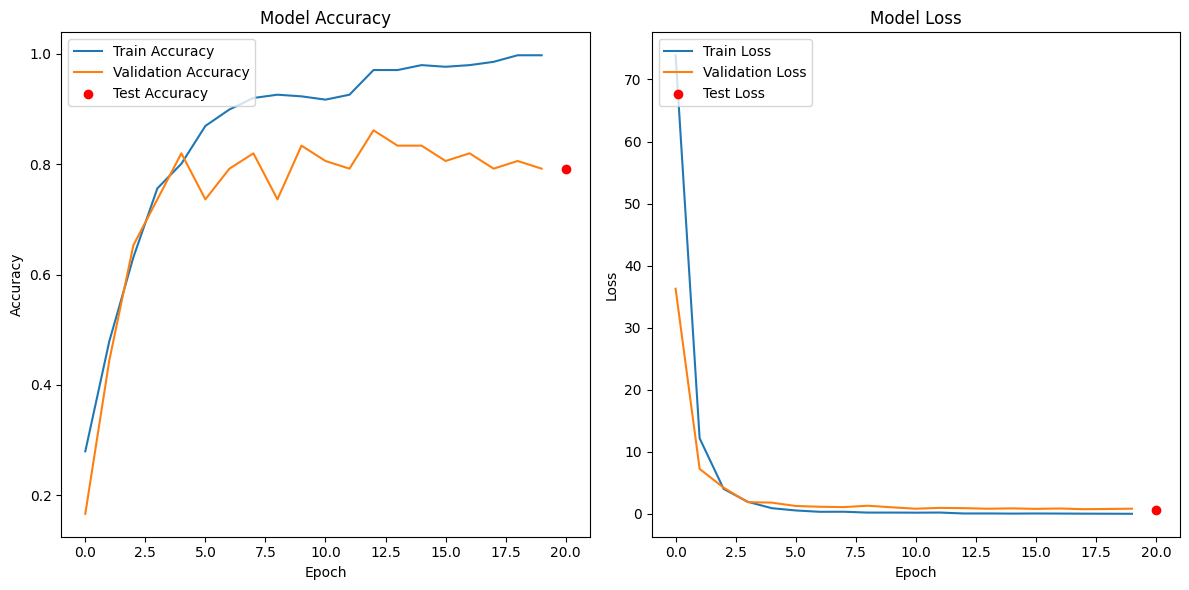

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from keras_tuner.tuners import BayesianOptimization
from keras_tuner import HyperParameters
from PIL import Image
import shutil

tuner_dir = 'my_dir/vgg16_tuning_2'
# Clear the existing tuner directory
#if os.path.exists(tuner_dir):
#    shutil.rmtree(tuner_dir)

# Load and preprocess data functions
def load_data(dataset_dir):
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    images = []
    labels = []

    for category in categories:
        path = os.path.join(dataset_dir, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            label = category
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  # Proper resizing using PIL
            img = np.array(img)
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

def preprocess_data(x, y):
    x = x / 255.0
    label_encoder = LabelEncoder()
    y_int = label_encoder.fit_transform(y)
    y = to_categorical(y_int, num_classes=4)
    return x, y, y_int, label_encoder

# Load data
x, y = load_data('dataset_16')

# Split the data: 70% training, 15% validation, 15% test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Normalize and preprocess images
x_train, y_train, y_train_int, label_encoder = preprocess_data(x_train, y_train)
x_val, y_val, y_val_int, _ = preprocess_data(x_val, y_val)
x_test, y_test, y_test_int, _ = preprocess_data(x_test, y_test)

# Display class distribution for training, validation, and test data
train_class_count = Counter(y_train_int)
val_class_count = Counter(y_val_int)
test_class_count = Counter(y_test_int)

print("Training set class distribution:", train_class_count)
print("Validation set class distribution:", val_class_count)
print("Test set class distribution:", test_class_count)

# Function to build the model
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(hp.Int('neurons', min_value=128, max_value=512, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1))(x)
    x = Dense(4, activation='softmax')(x)  # 4 output classes
    model = Model(inputs=base_model.input, outputs=x)
    
    for layer in base_model.layers:
        layer.trainable = False

    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'adamax'])
    if optimizer == 'adam':
        opt = Adam(learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0001]))
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0001]))
    elif optimizer == 'adamax':
        opt = Adamax(learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0001]))
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Setup Bayesian Optimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # You can increase this for more thorough search
    executions_per_trial=3,
    directory='my_dir',
    project_name='vgg16_tuning_2'
)

# Callbacks for early stopping and saving the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()

# Function to log and plot training history
def plot_accuracy(history, test_loss, test_accuracy):
    epochs = range(len(history.history['accuracy']))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.scatter(len(epochs), test_accuracy, label='Test Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.scatter(len(epochs), test_loss, label='Test Loss', color='red')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=callbacks)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print(f"Best Hyperparameters: {best_hp.values}")

# Rebuild the model with the best hyperparameters
model = build_model(best_hp)

# Train the model with the best hyperparameters and log the history
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(x_val, y_val, batch_size=32),
    epochs=20,
    callbacks=callbacks
)

# Evaluate the best model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Plot accuracy and loss
plot_accuracy(history, test_loss, test_accuracy)


### rebuilding after finding optimized hyper-parameters


neuron 512 

dropout 0

opt adamax 0.01

epoch 20

Training set class distribution: Counter({2: 93, 1: 91, 3: 78, 0: 74})
Validation set class distribution: Counter({3: 25, 1: 19, 0: 19, 2: 9})
Test set class distribution: Counter({0: 27, 2: 18, 3: 17, 1: 10})


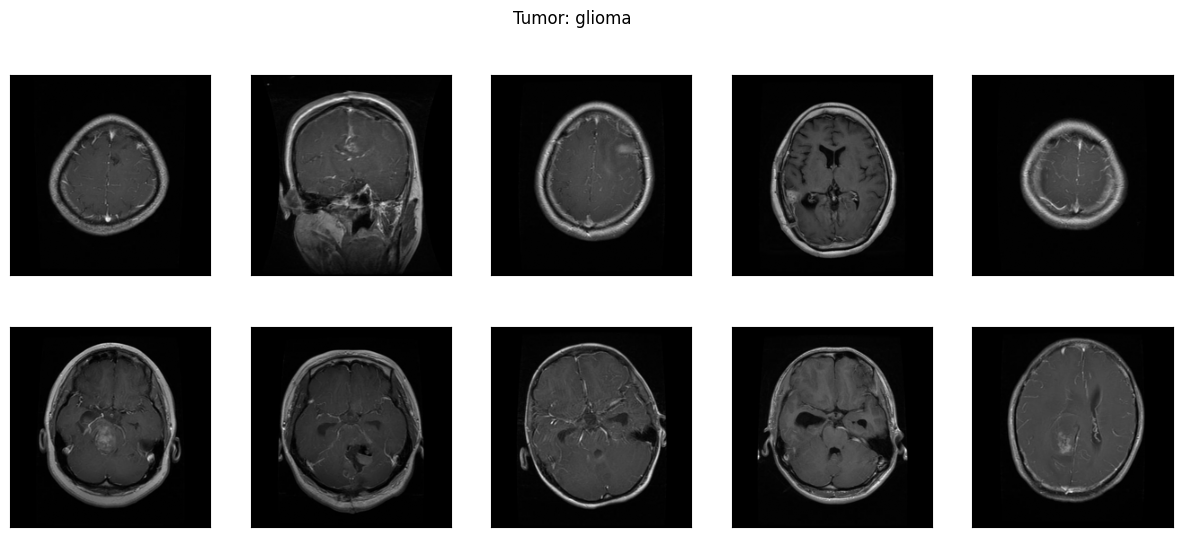

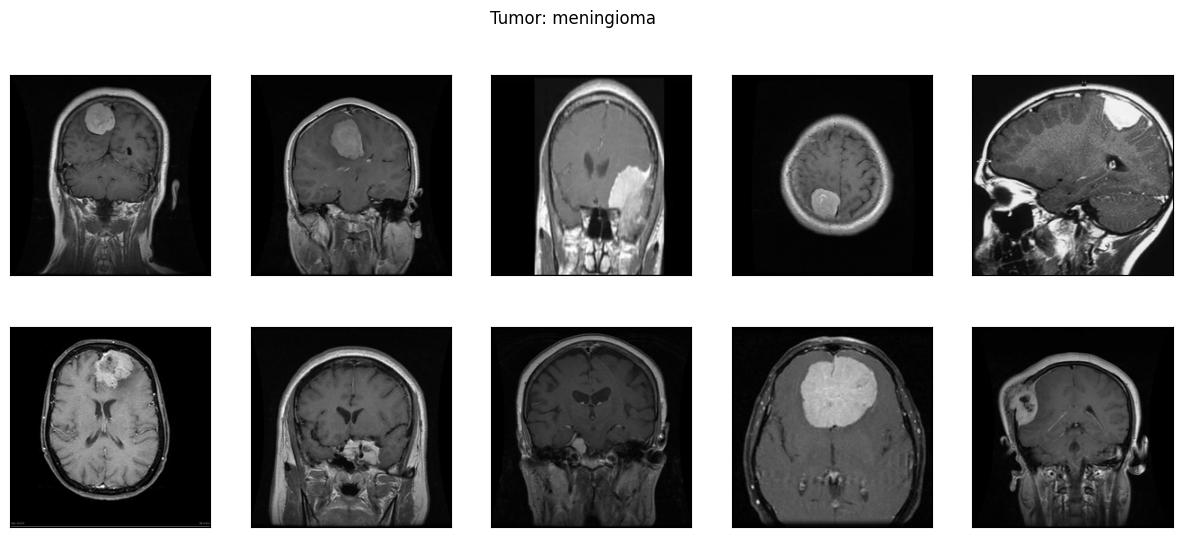

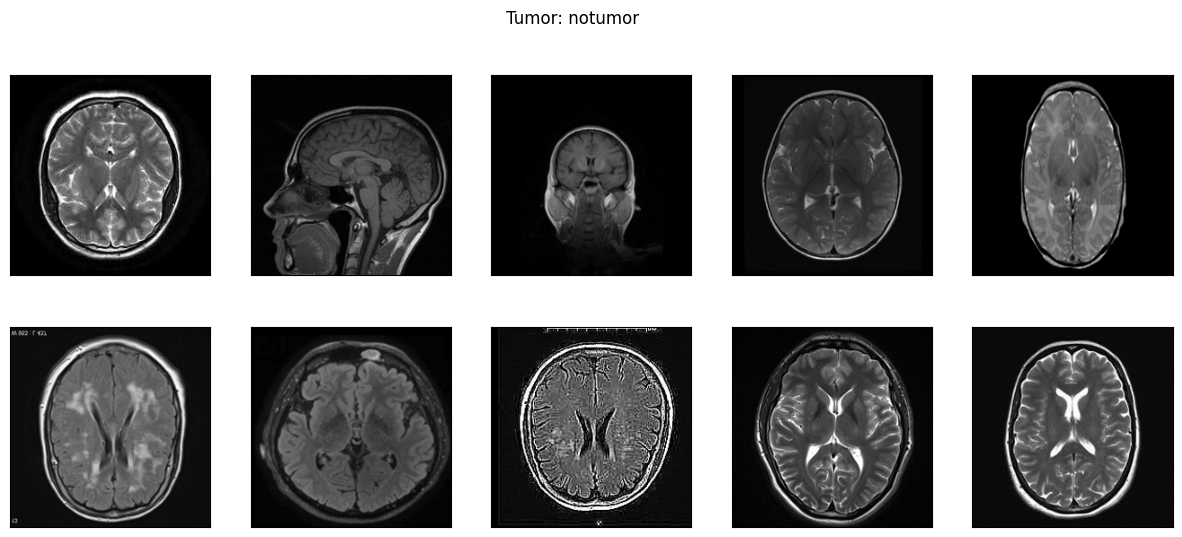

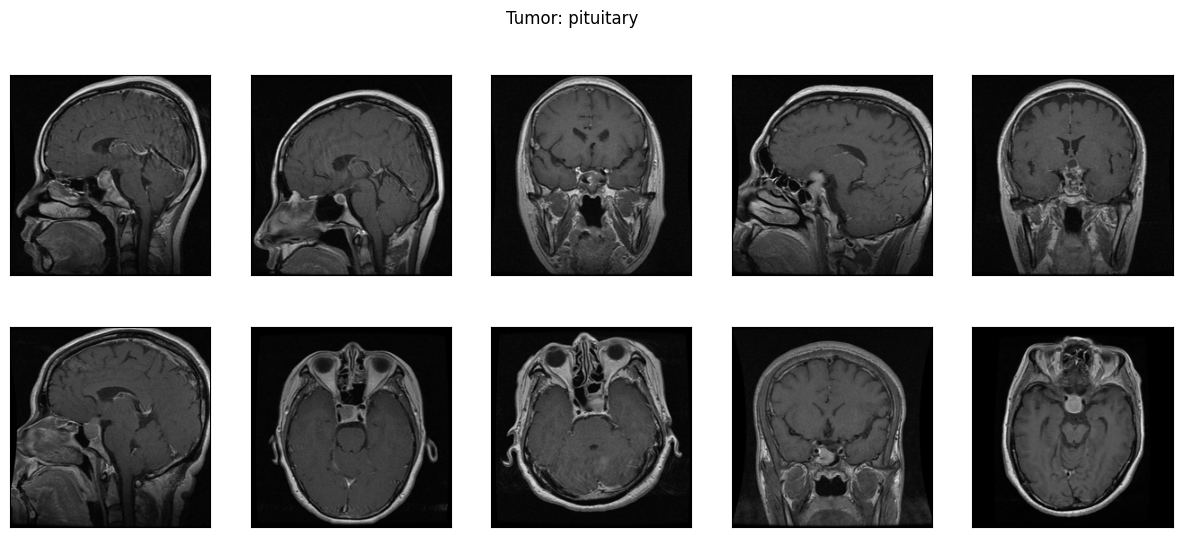

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20


/Users/oldmansteve/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3066 - loss: 47.1343 - val_accuracy: 0.3611 - val_loss: 29.4945
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5895 - loss: 16.5685 - val_accuracy: 0.6944 - val_loss: 6.6612
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.6809 - loss: 4.4133 - val_accuracy: 0.7639 - val_loss: 1.8160
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8520 - loss: 0.7018 - val_accuracy: 0.7500 - val_loss: 1.8783
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9182 - loss: 0.3039 - val_accuracy: 0.8611 - val_loss: 0.7764
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9779 - loss: 0.0705 - val_accuracy: 0.8056 - val_loss: 1.1036
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9795 - loss: 0.0609 - val_accuracy: 0.8611 - val_loss: 1.0261
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9788 - loss: 0.0565 - val_accuracy: 0.8194 - val_loss: 1.1545


Test Accuracy (VGG16): 84.72%
Model saved as VGG16_4.h5


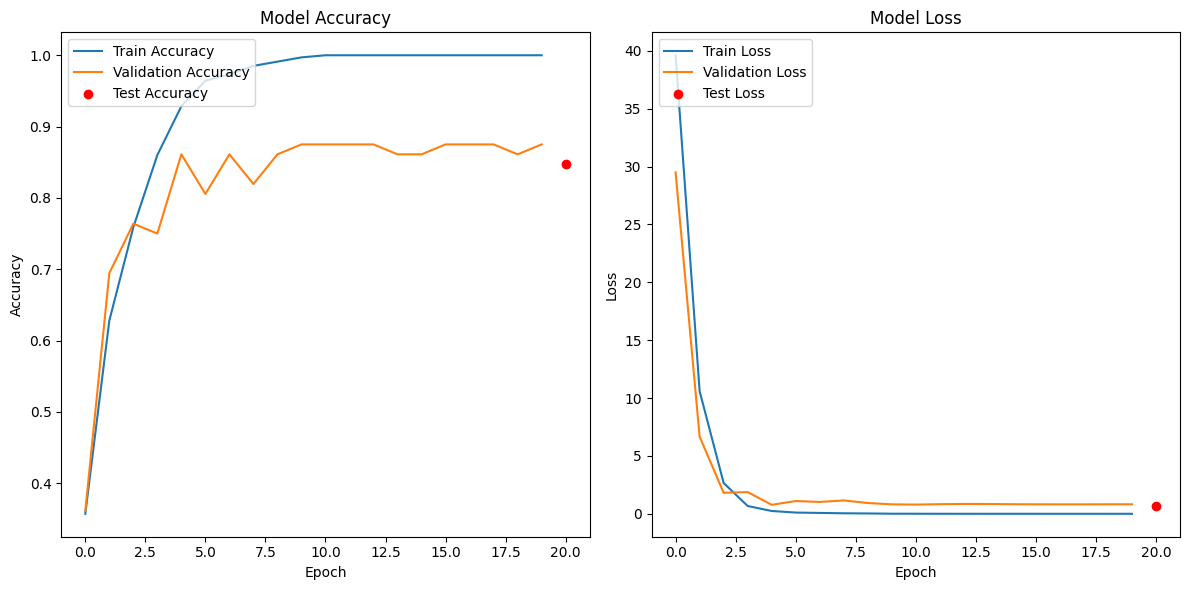

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


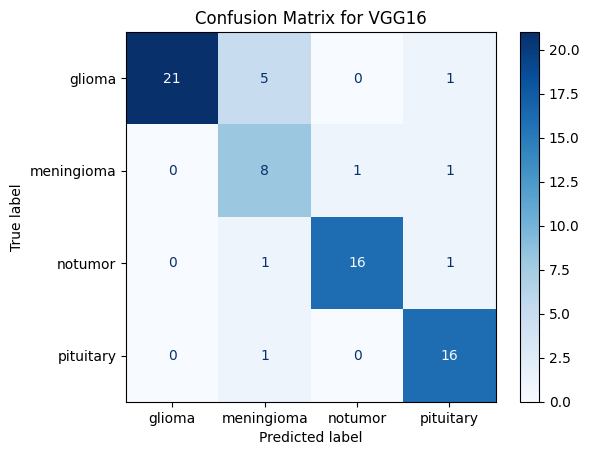

Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.78      0.88        27
  meningioma       0.53      0.80      0.64        10
     notumor       0.94      0.89      0.91        18
   pituitary       0.84      0.94      0.89        17

    accuracy                           0.85        72
   macro avg       0.83      0.85      0.83        72
weighted avg       0.88      0.85      0.86        72



In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter
from PIL import Image

# Load and preprocess data functions
def load_data(dataset_dir):
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    images = []
    labels = []

    for category in categories:
        path = os.path.join(dataset_dir, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            label = category
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  # Proper resizing using PIL
            img = np.array(img)
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

def preprocess_data(x, y):
    x = x / 255.0
    label_encoder = LabelEncoder()
    y_int = label_encoder.fit_transform(y)
    y = to_categorical(y_int, num_classes=4)
    return x, y, y_int, label_encoder

def plot_samples(X, y, labels_dict, n=10):
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n/j)

        plt.figure(figsize=(15, 6))
        c = 1
        for img in imgs:
            plt.subplot(i, j, c)
            plt.imshow(img[0])
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

def plot_accuracy(history, test_loss, test_accuracy):
    epochs = range(len(history.history['accuracy']))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.scatter(len(epochs), test_accuracy, label='Test Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.scatter(len(epochs), test_loss, label='Test Loss', color='red')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

def build_model(base_model):
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    #x = Dropout(0.1)(x)
    x = Dense(4, activation='softmax')(x)  # 4 output classes
    model = Model(inputs=base_model.input, outputs=x)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

# Load and preprocess data
x, y = load_data('dataset_16')
x, y, y_int, label_encoder = preprocess_data(x, y)

# Split the data: 70% training, 15% validation, 15% test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Display class distribution for training, validation, and test data
train_class_count = Counter(np.argmax(y_train, axis=1))
val_class_count = Counter(np.argmax(y_val, axis=1))
test_class_count = Counter(np.argmax(y_test, axis=1))

print("Training set class distribution:", train_class_count)
print("Validation set class distribution:", val_class_count)
print("Test set class distribution:", test_class_count)

# Plot sample images from training data
labels_dict = {i: label for i, label in enumerate(label_encoder.classes_)}
plot_samples(x_train, np.argmax(y_train, axis=1), labels_dict, 10)

# Image data augmentation
#train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

# Function to train and evaluate model
def train_and_evaluate_model(base_model, model_name, epochs=10):
    model = build_model(base_model)
    
    train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(x_val, y_val, batch_size=32)
    
    # Train the model
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=32)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"Validation Accuracy ({model_name}): {val_accuracy*100:.2f}%")
    
    test_generator = val_datagen.flow(x_test, y_test, batch_size=32)
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy ({model_name}): {test_accuracy*100:.2f}%")
    
    # Save the model
    model.save(f'{model_name}_4.h5')
    print(f"Model saved as {model_name}_4.h5")
    
    plot_accuracy(history, test_loss, test_accuracy)
    
    # Confusion matrix and classification report
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Print classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# VGG16 Model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
train_and_evaluate_model(vgg16_base, "VGG16", epochs=20)


### Testing with actual image performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


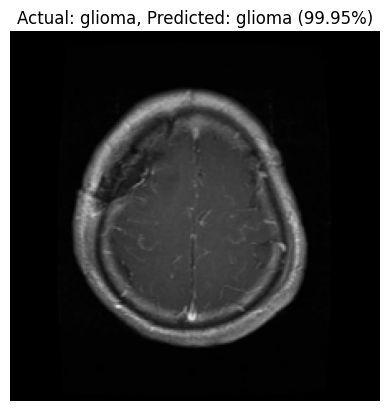

File Path: dataset_16/glioma/Tr-gl_0158.jpg
Predicted Probabilities: [[9.9954873e-01 4.5129581e-04 4.5359771e-10 5.8863054e-13]]


In [6]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Load the model
model = load_model('vgg16.h5')

# Function to load data (same as before)
def load_data(dataset_dir):
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    images = []
    labels = []
    file_paths = []

    for category in categories:
        path = os.path.join(dataset_dir, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            label = category
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  # Proper resizing using PIL
            img = np.array(img)
            images.append(img)
            labels.append(label)
            file_paths.append(img_path)

    return np.array(images), np.array(labels), file_paths

# Load and preprocess data
x, y, file_paths = load_data('dataset_16')

# Normalize the images
x = x / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)
y = tf.keras.utils.to_categorical(y_int, num_classes=4)

# Get a random image from the dataset
random_index = random.randint(0, len(x) - 1)
random_image = x[random_index]
actual_label = y[random_index]
actual_label_str = label_encoder.inverse_transform([np.argmax(actual_label)])[0]

# Preprocess the random image for prediction
random_image_expanded = np.expand_dims(random_image, axis=0)

# Make a prediction
predicted_probs = model.predict(random_image_expanded)
predicted_label_int = np.argmax(predicted_probs)
predicted_label_str = label_encoder.inverse_transform([predicted_label_int])[0]
confidence_score = np.max(predicted_probs) * 100

# Display the image, actual category, predicted category, and confidence score
plt.imshow(random_image)
plt.title(f'Actual: {actual_label_str}, Predicted: {predicted_label_str} ({confidence_score:.2f}%)')
plt.axis('off')
plt.show()

print(f"File Path: {file_paths[random_index]}")
print(f"Predicted Probabilities: {predicted_probs}")

